<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Regularización con Dropout<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-05</small></i></div>
                                                  

***

## Introducción

Pensemos brevemente en lo que se espera de un buen modelo predictivo. Queremos que funcione bien con datos no vistos. La teoría clásica de la generalización siempre ha sugerido que, para cerrar la brecha entre el rendimiento del modelo con los datos de entrenamiento y los de test, debemos aspirar a un modelo simple.

Sin embargo, en 2014 [Srivastava et. al](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). propusieron un nuevo punto de vista a la hora de generalizar. Curiosamente la analogía la realizaron con la reproducción sexual. Los autores argumentaron que el _overfitting_ de las redes neuronales se caracteriza por un estado en el que **cada capa se basa en un patrón específico de activaciones de la capa anterior**, lo que denominan **coadaptación**. El _dropout_, según ellos, rompe esta coadaptación de igual forma que la reproducción sexual rompe los genes coadaptados.

En esta técnica de regularización, se desactiva una fracción de las neuronas de cada capa, dejando la inferencia y el posterior entrenamiento a la fracción de nodos que fueron retenidos.

![Esquema de un MLP antes y después del aplicar Dropout](Images/dropout.png "Esquema de un MLP antes y después del aplicar Dropout")

Normalmente, desactivamos el Dropout en el momento que el entrenamiento ha finalizado y queremos probar el conjunto de test. No descartamos ningún nodo y, por tanto, no necesitamos normalizar. Sin embargo, existen algunas excepciones: algunos autores utilizan el _dropout_ también durante el cálculo de la exactitud con el conjunto de test como heurística de la incertidumbre de las predicciones de la red neuronal. Es decir, si las predicciones coinciden en muchas premutaciones diferentes de _dropout_ diferentes, entonces podríamos afirmar con cierta confianza que nuestro modelo es más seguro.

## Objetivos

El objetivo será la implementación de un modelo de perceptrón multicapa potente, que sea capaz de clasificar los datos del conjunto de datos mnist, pero que a su vez se haya regularizado mediante _dropout_ para intentar que su potencia no afecta a su capacidad de generalización.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del _notebook_.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

Configuraremos también algunos parámetros para adecuar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Preparación de los datos

Usaremos el dataset de `mnist` como hemos hecho hasta ahora:

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## Implementando _dropout_ con Keras

La verdad es que es extremadamente fácil. Con Keras (y en general con cualquier API de alto nivel), todo lo que tenemos que hacer es añadir una capa _Dropout_ tras la capa conectada a la que le queremos aplicar la regularización. El único parámetro a pasar al constructor es la probabilidad de que una neurona sea o no desactivada.

Durante el entrenamiento, la capa _Dropout_ dejará caer aleatoriamente las salidas de la capa anterior (y, por lo tanto, las entradas de la capa siguiente) de acuerdo con la probabilidad especificada. Cuando no está en modo de entrenamiento, la capa _Dropout_ simplemente pasa los datos sin modificarlos.

Veamos primero cómo funcionarían dos modelos similares para el problema del MNIST. Primero uno sin _dropout_

In [4]:
model_wo_do = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_wo_do.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])
model_wo_do.summary()

history_wo_do = model_wo_do.fit(x_train, y_train, epochs=100, validation_split=0.1, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Veamos cómo ha evolucionado el entrenamiento

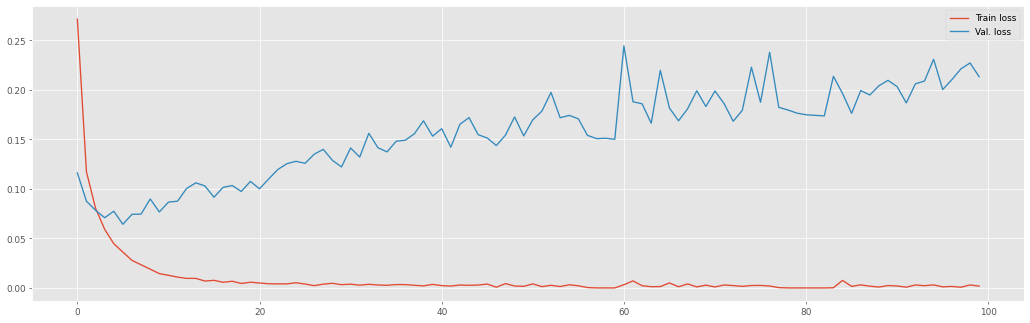

In [5]:
plt.plot(history_wo_do.history['loss'], label='Train loss')
plt.plot(history_wo_do.history['val_loss'], label='Val. loss')
plt.legend();

Y ahora uno con _dropout_:

In [6]:
model_wi_do = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_wi_do.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])
model_wi_do.summary()

history_wi_do = model_wi_do.fit(x_train, y_train, epochs=100, validation_split=0.1, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Y veamos también su evolución:

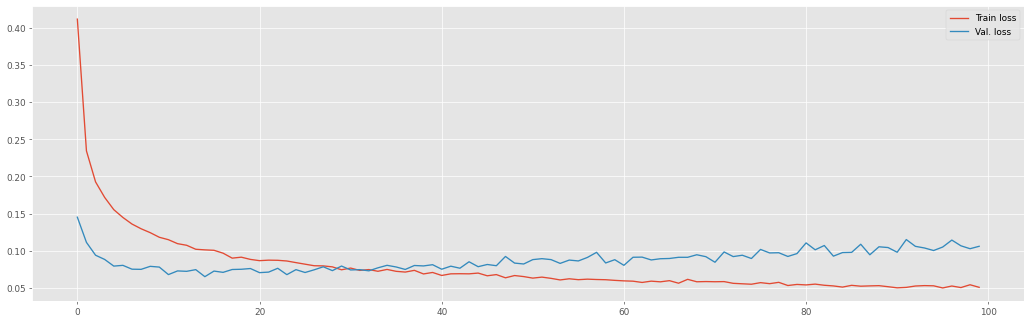

In [7]:
plt.plot(history_wi_do.history['loss'], label='Train loss')
plt.plot(history_wi_do.history['val_loss'], label='Val. loss')
plt.legend();

Vamos a comparar los valores que arrojan los conjuntos de ambos modelos:

In [8]:
print('Without dropout:')
train_loss_1, train_accuracy_1 = model_wo_do.evaluate(x_train, y_train, verbose=0)
test_loss_1, test_accuracy_1 = model_wo_do.evaluate(x_test, y_test, verbose=0)
print(f'\tLoss     -> Train: {train_loss_1}, Test: {test_loss_1}')
print(f'\tAccuracy -> Train: {train_accuracy_1}, Test: {test_accuracy_1}')
print('With dropout:')
train_loss_2, train_accuracy_2 = model_wi_do.evaluate(x_train, y_train, verbose=0)
test_loss_2, test_accuracy_2 = model_wi_do.evaluate(x_test, y_test, verbose=0)
print(f'\tLoss     -> Train: {train_loss_2}, Test: {test_loss_2}')
print(f'\tAccuracy -> Train: {train_accuracy_2}, Test: {test_accuracy_2}')

Without dropout:
	Loss     -> Train: 0.021667834371328354, Test: 0.21745522320270538
	Accuracy -> Train: 0.9978500008583069, Test: 0.9779999852180481
With dropout:
	Loss     -> Train: 0.014979350380599499, Test: 0.13665316998958588
	Accuracy -> Train: 0.9970999956130981, Test: 0.9779999852180481


Generalmente los valores de error que arrojan los modelos que han sido entrenados con dropout suelen ser más altos. Esto es debido a que en estos modelos no hemos entrenado todas las conexiones a la vez, sino que hay conexiones que no se entrenan y eso implica que hay que entrenarlos durante más epochs.

Sin embargo, la tendencia general que se observa es que en modelos muy potentes el conocimiento tiende a repartirse por todas las conexiones del modelo, haciendo que la sobrespecialización se mitigue y la generalización aumente.

## Conclusiones

Hemos realizado una comparativa entre dos modelos, uno sin dropout y otro con él, y hemos demostrado que el uso de dropout puede mejorar significativamente la capacidad predictiva de los modelos. Además, hemos explicado cómo funciona el dropout y cómo se puede ajustar su hiperparámetro para optimizar su rendimiento.

En resumen, el uso de _dropout_ puede mejorar enormemente la capacidad predictiva de nuestro modelos y mantener su capacidad de generalización gracias a que favorece que los modelos muy potentes no se estanquen en la sobrespecialización.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>